# Sentiment Analysis & Expression Retrieval

_**Authors:** Hyder Ali (Preprocessing, EDA-Document Distributions, EDA-Valence Score Distributions); Matthias Oh (Understanding VADER, VADER package customization, Expression Retrieval, EDA with Expression Retrieval)_

## Important note:
The pip-installed vaderSentiment package used for this project has been forked from the original Github repository, and includes an additional val2vec() method under the SentimentIntensityAnalyzer() function.

To run the codes in this notebook, you will have to pip uninstall any existing versions of vaderSentiment, and then pip install vaderSentiment from Matthias' Github repo, by using the command "pip install git+https://github.com/mattoh91/vaderSentiment.git".

## I. Pre-processing and Set-up

In [3]:
from nltk.corpus import PlaintextCorpusReader
file_directory = 'C:/Users/matthiasoh/Desktop/Matt/Text/SGNews'
filename_pattern = '.+\.txt'

my_corpus = PlaintextCorpusReader(file_directory, filename_pattern)

fids = my_corpus.fileids()
#Generate list of labels.
labels = [f.split('_')[0] for f in fids]
#Generate list of list of words.
docs = [my_corpus.words(f) for f in fids]
#Generate list of list of words, unseparated as a single element in the list.
docs = [' '.join(lst) for lst in docs]

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
    
list_polarity_scores = [analyser.polarity_scores(doc) for doc in docs]
list_neg_score = [doc['neg'] for doc in list_polarity_scores]
list_neu_score = [doc['neu'] for doc in list_polarity_scores]
list_pos_score = [doc['pos'] for doc in list_polarity_scores]
list_com_score = [doc['compound'] for doc in list_polarity_scores]

## II. Sentiment Expression Retrieval

### Create Dataframe of Documents and Valence Scores

In [31]:
import numpy as np
import pandas as pd

sentiment_score = pd.DataFrame(data = {'Label': labels, 'File_Name': fids, 'Compound': list_com_score, 
                                       'Positive': list_pos_score, 'Negative': list_neg_score,
                                       'Neutral': list_neu_score})
sentiment_score['Overall'] = np.NaN

def compute_sentiment (compound):
    if float(compound) < -0.25:
        return 'Negative'
    #Define a neutral compound score to be within the range of -0.25 <= neutral score <= 0.25.
    elif float(compound) >= -0.25 and float(compound) <= 0.25 :
        return 'Neutral'
    else:
        return 'Positive'

sentiment_score['Overall'] = sentiment_score['Compound'].apply(lambda x: compute_sentiment(x))

### Understanding VADER

In [6]:
sentiment_score.head()

,Label,File_Name,Compound,Positive,Negative,Neutral,Overall
0,Asia,Asia_10005.txt,0.9921,0.235,0.095,0.670,Positive
1,Asia,Asia_10006.txt,-0.9719,0.014,0.098,0.888,Negative
2,Asia,Asia_10014.txt,0.9838,0.111,0.019,0.869,Positive
3,Asia,Asia_10015.txt,-0.8020,0.061,0.078,0.861,Negative
4,Asia,Asia_10016.txt,-0.9245,0.033,0.099,0.868,Negative


**The Attributes**

The compound score is the overall sentiment representation of an article, ranging from -1 (very negative sentiment) to 1 (very positive). For the purpose of this project, we have defined a neutral score to span the range from -0.25 to 0.25 inclusive.

The "Overall" attribute was derived using our own created function "compute_sentiment()", which parses compound score as the input *args.

**An Interesting Note**

The Negative, Neutral, and Positive scores per row all add up to 1. These scores are to be distinguished from the compound valence score, in that they are a mixed score accounting for valence and word occurrence. With respect to the tokens within an article:
* Total = (sum(positive valence scores+1) + (|sum(negative valence scores)|-1) + count(tokens with neutral scores)
* Positive = (sum(positive valence scores) + 1)/Total
* Negative = (sum(negative valence scores) - 1)/Total
* Neutral = count(tokens with neutral scores)/Total


The Neutral score will always be the highest value because every piece of text consists mostly of neutral words.

Thus, the compound valence score is the true representation of sentiment. If one wishes to use the Positive and Negative scores, they should be compared without the Neutral score.

### Creating New Functionality

VADER lacks the functionality of extracting sentiment expressions. Functions to facilitate sentiment expression extraction had to be manually created and inserted into a fork of VADER's Github repository: https://github.com/mattoh91/vaderSentiment.git.

**The "val2vec()" Function**

The "val2vec()" function has been added into a fork of VADER's Github repo; a [screenshot](https://github.com/mattoh91/vaderSentiment/blob/master/images/val2vec_screenshot.JPG) of the function code and its corresponding code line numbers has also been uploaded for easier reference. 

Most of the code logic is the same with an exisitng method "polarity_scores()", however this function returns a vector space model object of valence scores corresponding to tokens within an article. This object was identified after studying the underlying code of the vaderSentiment package. The "val2vec()" function facilitates sentiment expression extraction when used in conjunction with another custom created function val_expr(), which is discussed below.

**The "val_expr()" Function**

This function takes in *args (1) token list and (2) valence score list, and returns output of a dataframe consisting (1) sentiment-relevant tokens, (2) token's related valence score, and (3) passage that token was found in.
This function is used on a document-level, ie. parses 1 document at a time.
This function was not committed to the original vaderSentiment master branch on Github because the author

In [7]:
def val_expr(tokenlist,valscorelist):
    '''
    Input arguments
    *args tokenlist: Bag of words of a single document within the corpus.
    *args valscorelist: Vector space model (non-sparse) of valence scores per token within a single document.
    
    Intermediate outputs
    expressions: Sentiment-relevant token.
    expr_score: Sentiment-relevant token's valence score.
    expr_passage: Passage containing the sentiment-relevant token, extracted using bi-directional expansion.
    
    Returned output
    val_expr_df: Pandas dataframe consisting the 3 intermediate outputs.
    '''
    expressions = []
    expr_score = []
    expr_passage = []
    
    #Iterate through vector space model of valence scores.
    for i in valscorelist:
        if i != 0:
            refindex = valscorelist.index(i)
            expr = tokenlist[refindex]
            #Bi-directional expansion of identified sentiment-relevant token, to extract surrounding passage, as a string.
            expr_p = ' '.join(tokenlist[refindex-5:refindex+6])
            expressions.append(expr)
            expr_score.append(round(i,2))
            expr_passage.append(expr_p)
            #Replace i with 0 to prevent index from picking up the same instance of a token if the next token is also the same word.
            valscorelist[refindex] = 0
        else:
            continue
    val_expr_df = pd.DataFrame({'Expression': expressions, 'Valence_Score': expr_score, 'Related_Passage': expr_passage},\
                               columns = ['Expression','Valence_Score','Related_Passage'])
    return val_expr_df

### Sentiment Expression Extraction - A Test Case

Filter for articles with Singapore label and positive compound score, and select one of the listed articles for sentiment expression extraction.

In [17]:
df_filtered = sentiment_score.query('Label == "World" & Overall == "Neutral"')
df_filtered[0:9]

,Label,File_Name,Compound,Positive,Negative,Neutral,Overall
5689,World,World_10004.txt,0.0129,0.050,0.049,0.901,Neutral
5725,World,World_10221.txt,-0.0772,0.077,0.069,0.854,Neutral
5749,World,World_10318.txt,-0.0772,0.086,0.080,0.834,Neutral
5762,World,World_10354.txt,-0.1406,0.052,0.049,0.899,Neutral
5771,World,World_10433.txt,-0.2210,0.066,0.082,0.852,Neutral
5772,World,World_10459.txt,-0.2109,0.081,0.076,0.843,Neutral
5778,World,World_10465.txt,0.0893,0.095,0.074,0.832,Neutral
5814,World,World_10607.txt,-0.0569,0.077,0.063,0.861,Neutral
5828,World,World_10695.txt,0.2340,0.116,0.113,0.771,Neutral


Extract the first 10 sentiment expressions (not sorted).

In [24]:
#SentiText returns a processed bag of words (stemmed and lemmatized) and emoticons free from leading and trailing punctuation.
from vaderSentiment.vaderSentiment import SentiText as senttext
pd.options.display.max_colwidth = 120

prepro_tokens = senttext(' '.join(my_corpus.words('World_10607.txt'))).words_and_emoticons
valscore_vec = analyser.val2vec(' '.join(my_corpus.words('World_10607.txt')))

test_expr_df = val_expr(prepro_tokens,valscore_vec)

In [25]:
#Return top 10 tokens with by lowest valence score.
test_expr_df.sort_values(['Valence_Score'], ascending=[True])[0:9]

,Expression,Valence_Score,Related_Passage
7,illegal,-3.25,available throughout the country This illegal market has had significant impact
6,fake,-2.10,government pledges to root out fake goods these are still widely
12,fakes,-2.06,recently seized more than 000 fakes bottles of Chateau Lafite There
10,losses,-1.70,of millions of euros in losses Counterfeit bottles of Bordeaux Chateau
18,fight,-1.60,"is efficient in terms of fight against counterfeiting ,"" he added"
1,battle,-1.60,an agreement with Beijing to battle counterfeits would likely be signed
3,fight,-1.60,"protocol of cooperation on the fight against counterfeiting ,"" Dacian Ciolos"
14,want,0.30,From our institutional side we want to be sure that this
16,legal,0.50,to be sure that this legal framework really exists and that


In [26]:
#Return top 10 tokens with highest valence score.
test_expr_df.sort_values(['Valence_Score'], ascending=[False])[0:9]

,Expression,Valence_Score,Related_Passage
0,agreement,2.20,for agriculture said Tuesday an agreement with Beijing to battle counterfeits
11,popular,2.09,Bordeaux Chateau Lafite wine hugely popular in China where it embodies
9,good,1.90,particularly Bordeaux wineries that have good reputation in China Exports of
17,efficient,1.80,exists and that it is efficient in terms of fight against
15,sure,1.30,side we want to be sure that this legal framework really
4,important,0.80,trip to Beijing This is important especially for our wines and
5,important,0.80,and spirits It our most important part of exports of agricultural
8,significant,0.80,This illegal market has had significant impact on European winemakers including
2,spirit,0.70,for the region wine and spirit sector think that in September


## III. EDA with Sentiment Expressions

### Plot Number of Documents Per Article Category

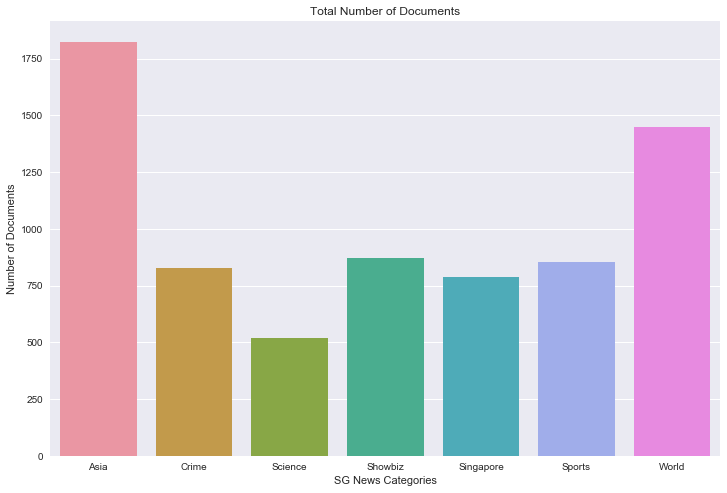

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = "darkgrid")
plt.figure(figsize = (12,8))
fig = sns.countplot(data = sentiment_score, x = "Label")
plt.xlabel("SG News Categories")
plt.ylabel("Number of Documents")
plt.title("Total Number of Documents")
plt.show(fig)

### Plot Sentiment Frequency Distribution Per Article Category

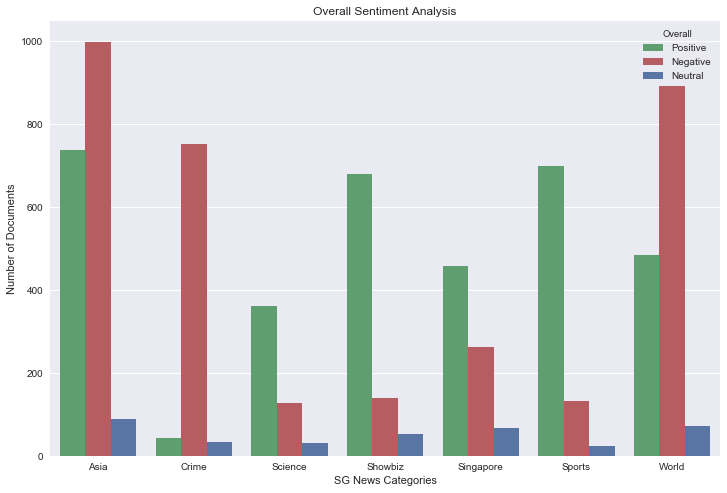

In [28]:
sns.set(style = "darkgrid")
plt.figure(figsize = (12,8))

fig = sns.countplot(data = sentiment_score, x = "Label", hue = "Overall", palette = ["C1", "C2", "C0"])
plt.xlabel("SG News Categories")
plt.ylabel("Number of Documents")
plt.title("Overall Sentiment Analysis")
plt.show(fig)

### Plot Valence Compound Score per Article Category

Visualize via density plot.

Text(0.5,0.98,'Density Plots of Compound Sentiment Score')

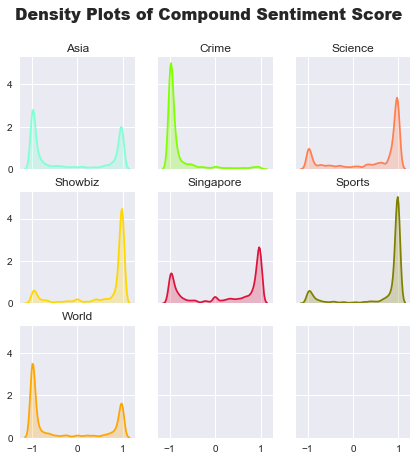

In [29]:
f, axes = plt.subplots(3, 3, figsize = (7,7), sharex = True, sharey = True)
sns.set_style("white")
sns.despine(left = True, bottom = True)
axes[0,0].set_title('Asia')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Asia']['Compound'], shade = True, bw = 0.05, color = "aquamarine",legend = False, ax = axes[0,0])
axes[0,1].set_title('Crime')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Crime']['Compound'], shade = True, bw = 0.05, color = "chartreuse", legend = False, ax = axes[0,1])
axes[0,2].set_title('Science')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Science']['Compound'], shade = True, bw = 0.05, color = "coral", legend = False, ax = axes[0,2])
axes[1,0].set_title('Showbiz')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Showbiz']['Compound'], shade = True, bw = 0.05, color = "gold", legend = False, ax = axes[1,0])
axes[1,1].set_title('Singapore')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Singapore']['Compound'], shade = True, bw = 0.05, color = "crimson", legend = False, ax = axes[1,1])
axes[1,2].set_title('Sports')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'Sports']['Compound'], shade = True, bw = 0.05, color = "olive", legend = False, ax = axes[1,2])
axes[2,0].set_title('World')
sns.kdeplot(sentiment_score[sentiment_score['Label'] == 'World']['Compound'], shade = True, bw = 0.05, color = "orange", legend = False, ax = axes[2,0])
f.suptitle('Density Plots of Compound Sentiment Score', fontsize=16, weight = 1000)

Alternative visualization via violin plot.

Text(0,0.5,'Compound Sentiment Score')

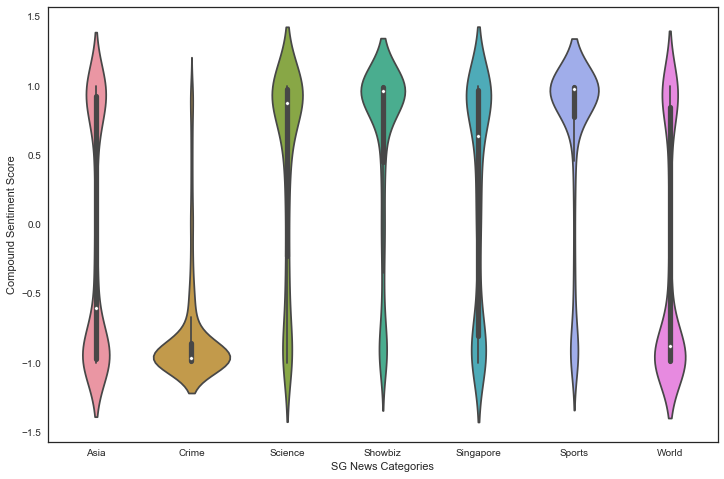

In [30]:
plt.figure(figsize = (12,8))
fig = sns.violinplot(data = sentiment_score, x = "Label", y = "Compound")
plt.xlabel("SG News Categories")
plt.ylabel("Compound Sentiment Score")

### Supplementary EDA

<img src="DensityPlots.png" alt="Density Plots" width="400px" style="float:left"/>

The compound sentiment score distribution per article label were shown in Section II. EDA. (see density plots above). This section seeks to document the incorporation of sentiment expression retrieval to supplement initial EDA.

### EDA into Negative Crime Article Example

Based on the density plots, look into an article label which is inherently negative: Crime.

Filter and sort to identify the most negative Crime article within the Crime sub-corpus.

In [51]:
df_EDA_filtered = sentiment_score.query('Label == "Crime" and Compound < 0')
df_EDA_filtered.sort_values(['Compound'],ascending=[True]).head()

,Label,File_Name,Compound,Positive,Negative,Neutral,Overall
2517,Crime,Crime_16172.txt,-0.9998,0.067,0.169,0.764,Negative
1858,Crime,Crime_10299.txt,-0.9995,0.100,0.195,0.705,Negative
2295,Crime,Crime_14052.txt,-0.9992,0.050,0.204,0.747,Negative
1916,Crime,Crime_10665.txt,-0.9989,0.011,0.203,0.786,Negative
1979,Crime,Crime_11197.txt,-0.9986,0.068,0.162,0.770,Negative


Article "Crime_16172.txt" is the chosen example for this EDA exercise.

Use the sentiment expression retrieval functions to retrieve non-neutral tokens (valence score < -0.25 | valence score > 0.25). 

Wrangle the resulting pandas dataframe into a list and then into a string, for ingestion into the wordcloud package for wordcloud generation.

(-0.5, 399.5, 199.5, -0.5)

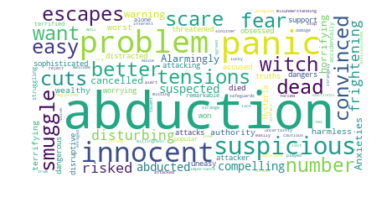

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Use val_expr() to facilitate removal of neutral terms below.
prepro_tokens = senttext(' '.join(my_corpus.words('Crime_16172.txt'))).words_and_emoticons
valscore_vec = analyser.val2vec(' '.join(my_corpus.words('Crime_16172.txt')))
test_wc_df = val_expr(prepro_tokens,valscore_vec)

#Remove neutral terms to eliminate noise from word cloud.
test_wc_df = test_wc_df.query('Valence_Score > 0.25 | Valence_Score < -0.25')
test_wc_l = test_wc_df['Expression'].tolist()
test_wc_s = ' '.join(test_wc_l)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(test_wc_s)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### EDA into Positive Sports Article Example

Based on the density plots, look into an article label which is inherently positive: Sports.

Filter and sort to identify the most positive Sports article within the Sports sub-corpus.

In [53]:
df_EDA_filtered = sentiment_score.query('Label == "Sports" and Compound > 0')
df_EDA_filtered.sort_values(['Compound'],ascending=[False]).head()

,Label,File_Name,Compound,Positive,Negative,Neutral,Overall
5183,Sports,Sports_12633.txt,0.9998,0.231,0.087,0.682,Positive
5612,Sports,Sports_9403.txt,0.9998,0.159,0.011,0.830,Positive
5125,Sports,Sports_12163.txt,0.9997,0.295,0.026,0.680,Positive
5268,Sports,Sports_13432.txt,0.9996,0.167,0.023,0.810,Positive
5179,Sports,Sports_12599.txt,0.9995,0.228,0.017,0.755,Positive


Article "Sports_12633.txt" is the chosen example for this EDA exercise.

Use the sentiment expression retrieval functions to retrieve non-neutral tokens (valence score < -0.25 | valence score > 0.25). 

Wrangle the resulting pandas dataframe into a list and then into a string, for ingestion into the wordcloud package for wordcloud generation.

(-0.5, 399.5, 199.5, -0.5)

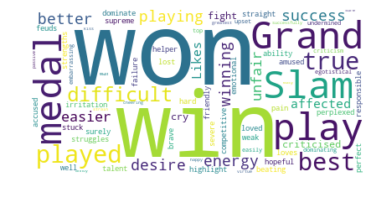

In [55]:
prepro_tokens = senttext(' '.join(my_corpus.words('Sports_12633.txt'))).words_and_emoticons
valscore_vec = analyser.val2vec(' '.join(my_corpus.words('Sports_12633.txt')))
test_wc_df = val_expr(prepro_tokens,valscore_vec)

#Remove neutral terms to eliminate noise from word cloud.
test_wc_df = test_wc_df.query('Valence_Score > 0.25 | Valence_Score < -0.25')
test_wc_l = test_wc_df['Expression'].tolist()
test_wc_s = ' '.join(test_wc_l)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(test_wc_s)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")